![Alt text](./watson_image.png)




# <a id="asso-title"> Recommendations for Articles with IBM </a>


### Building a recommendation system for data science articles on the IBM Watson Studio. 

<br/><br/>



## <a id="toc">  Table of Content. </a>

- Notebook I: Data Collection, Cleaning, and EDA.


- Notebook II: Rank-Based Recommendations.


- Notebook III: Collaborative Filtering: Neighbor-based.


- Notebook IV: Collaborative Filtering: Matrix Factorization.


- Notebook V: More EDA, Preprocessing, Content-based Recommendation.






## <a id="notebook1"> This is Notebook I: Data Cleaning and EDA.</a>

0. [Data Loading and overview.](#Loading)<br>


1. [Data Cleaning.](#Cleaning)<br>

        1.1 redundant columns and unmatching dtypes.
        
        1.2 missing data and obscure data.
     
        1.3 duplication. 
    
     
2. [EDA.](#Exploratory-Data-Analysis)<br>

        2.1 distribution of number of items/articles.
    
        2.2 distribution of number of users.
   

3. [Data Saving.](#save)<br>

In [80]:
# This is Python 3 environment, with Anaconda distribution of standard libraries.
# Additional module may needed: pickle.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline
plt.style.use('seaborn')

## <a class="anchor" id="Loading"> Part 0: Data Loading and Overview.</a>

In [81]:
# Read a prepared dataset to start with
# We shall collect more data via the IBM Watson API later
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')

# overview of df
df.head()

,Unnamed: 0,article_id,title,email
0,0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [82]:
# Show df_content to get an idea of the data
df_content.head()

,Unnamed: 0,doc_body,doc_description,doc_full_name,doc_status,article_id
0,3,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,5,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,7,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,8,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,12,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [83]:
df.dtypes

Unnamed: 0      int64
article_id    float64
title          object
email          object
dtype: object

In [84]:
df_content.dtypes

Unnamed: 0          int64
doc_body           object
doc_description    object
doc_full_name      object
doc_status         object
article_id          int64
dtype: object

#### First impression: 


1. df records the user-article interactions, there are 45993 records (may have duplicates, see below).


2. df_content contains articles information such as document name, description, and body text. df also contains article title which can be different from df.title.


3. the df.email column is obscure, should re-encode it.


4. the relational keys, df.article_id and df_content.article_id, have different dtypes, should make them match.


## <a class="anchor" id="Cleaning">Part 1 : Data Cleaning</a>
 

### `1.1` redundant columns and data types.

In [89]:
# validation: df_content['Unnamed: 0'] is probably older indices, no clear meaning.
len(df_content['Unnamed: 0'].unique())==len(df_content)

True

In [90]:
# delete redundant columns
try:
    del df['Unnamed: 0']
    del df_content['Unnamed: 0']
except:
    print('Columns may have been deleted. There was an error.')

In [91]:
# change dtype of df.article_id, so that it match with df_content.article_id
df['article_id'] = df.article_id.astype('int')

In [92]:
df.dtypes

article_id     int64
title         object
email         object
dtype: object

In [93]:
df.shape

(45993, 3)

In [94]:
df_content.shape

(1056, 5)

### `1.2` the "df.email" column: missing data and re-encoding.

In [95]:
# look for obvious missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  45993 non-null  int64 
 1   title       45993 non-null  object
 2   email       45976 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [96]:
# take a look at the missing data
df[df.email.isna()]

,article_id,title,email
25131,1016,why you should master r (even if it might even...,NaN
29758,1393,the nurse assignment problem,NaN
29759,20,working interactively with rstudio and noteboo...,NaN
29760,1174,breast cancer wisconsin (diagnostic) data set,NaN
29761,62,data visualization: the importance of excludin...,NaN
35264,224,"using apply, sapply, lapply in r",NaN
35276,961,beyond parallelize and collect,NaN
35277,268,sector correlations shiny app,NaN
35278,268,sector correlations shiny app,NaN
35279,268,sector correlations shiny app,NaN


There is a small number of null values. An external information indicates that all of these null values likely belonged to a single user.

We shall use the `email_mapper` function below to map emails to user_ids.  

In [97]:
# map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

try:
    email_encoded = email_mapper()
    del df['email']
    df['user_id'] = email_encoded
except KeyError:
    print('The column "email" may has been transformed. There was an KeyError.' )

# show header
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


### `1.3` Explore and remove duplicate articles from the **df_content** dataframe.  

In [12]:
# Find and explore duplicate articles
df_content[df_content['article_id'].duplicated(keep=False)].sort_values('article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [13]:
df_content.shape

(1056, 5)

In [14]:
# drop duplicated articles
try:
    duplic_index = df_content[df_content.duplicated(subset=['article_id'],keep='first')].index
    df_content.drop(index=duplic_index, inplace=True)
except:
    print('Duplicates may have been deleted. There was an error.')

df_content.shape

(1051, 5)

<br></br>

## <a class="anchor" id="EDA">Part 2 : Exploratory Data Analysis </a>

### `2.1` Distribution of how many articles a user interacts with in the dataset. 

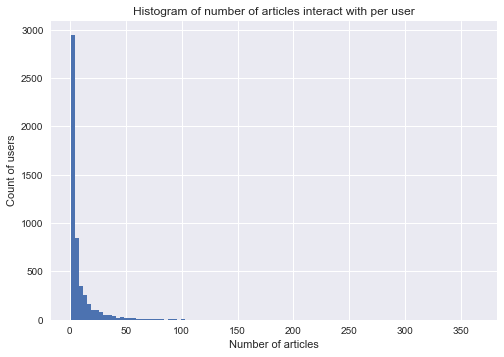

In [98]:
# group by user
grouped = df.groupby('user_id')
# article counts per user
n_articles_per_user = grouped.count()['article_id']


# distribution of numbers of articles per user
plt.hist(n_articles_per_user, bins=100)
plt.ylabel('Count of users')
plt.xlabel('Number of articles')
plt.title('Histogram of number of articles interact with per user')
plt.show()

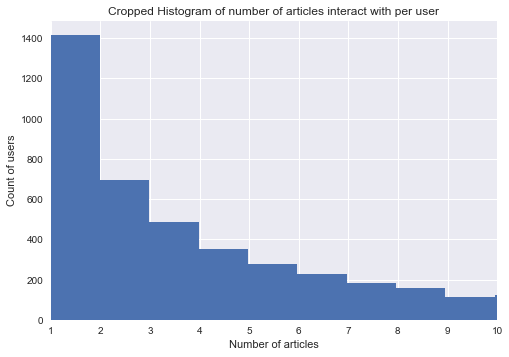

In [99]:
# distribution of numbers of articles from 1 to 10.
plt.hist(n_articles_per_user, bins=365)
plt.xlim(1,10)
plt.ylabel('Count of users')
plt.xlabel('Number of articles')
plt.title('Cropped Histogram of number of articles interact with per user')
plt.show()

#### Boxplot for viewing the tail

/Users/hchen/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


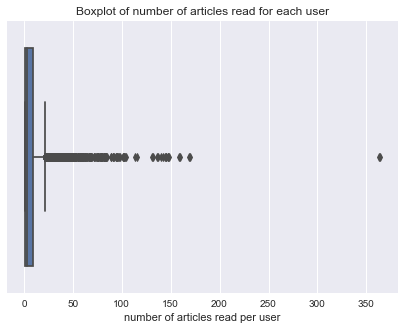

In [101]:
# boxplot
fig, ax = plt.subplots(figsize=(7,5))
ax=sns.boxplot(n_articles_per_user)
ax.set_xlabel('number of articles read per user')
plt.title('Boxplot of number of articles read for each user')
plt.show()


/Users/hchen/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'log-scale: count of articles read for each user')

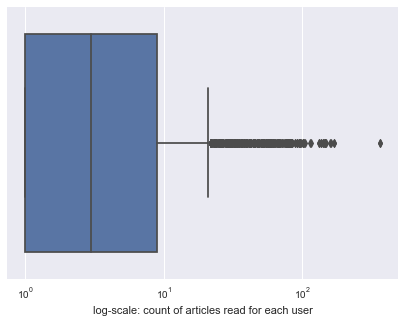

In [10]:
# log-scale boxplot
fig, ax = plt.subplots(figsize=(7,5))
ax=sns.boxplot(n_articles_per_user)
ax.set_xscale('log')
ax.set_xlabel('log-scale: count of articles read for each user')

In [100]:
# some summary statistics
median_val = n_articles_per_user.median() 
max_views_by_user = n_articles_per_user.max()
print(f'50% of individuals interact with {median_val} number of articles or fewer.')
print(f'The maximum number of user-article interactions by any 1 user is {max_views_by_user}.')

50% of individuals interact with 3.0 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


#### Conclusions:

1. The number of viewed articles per user has a exponential decay distribution. 


2. But it has a long tail and the maximum is an outlier in some sense.


3. So, for the user-item matrix we'll make later, we mainly have two options:

    a. use 0 and 1, only encode if an article is viewed or not, regardless how many times;
    b. merge the tail into one category and use a smaller scaler, say 0 - 4 and 5+.

### `2.2` Distributions of how many views each article has

<br></br>

Some statistics:


**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [102]:
# The number of unique articles that have at least one interaction
unique_articles = df.article_id.unique().shape[0] 
# The number of unique articles on the IBM platform
total_articles = df_content.article_id.unique().shape[0]
# The number of unique users
unique_users = df.user_id.nunique()
# The number of user-article interactions
user_article_interactions = len(df)

In [103]:
unique_articles, total_articles, unique_users, user_article_interactions

(714, 1051, 5149, 45993)

In [104]:
num_reads = df.groupby('article_id').count().sort_values('title', ascending=False)
num_reads.iloc[:5]

,title,user_id
article_id,,
1429,937,937
1330,927,927
1431,671,671
1427,643,643
1364,627,627


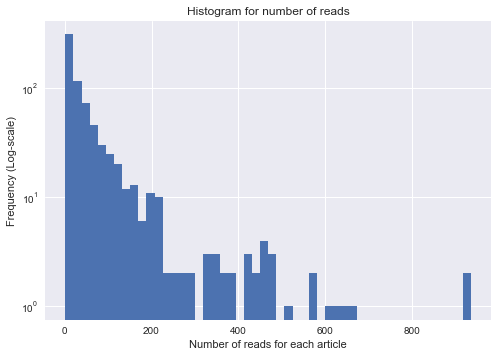

In [105]:
# log-scale histogram
plt.hist(num_reads['title'], bins=50)
plt.yscale('log')
plt.ylabel('Frequency (Log-scale)')
plt.xlabel('Number of reads for each article')
plt.title('Histogram for number of reads')
plt.show()

In [106]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(df.groupby('article_id').count().sort_values('user_id', ascending=False).index[0])
max_views = df.groupby('article_id').count().sort_values('user_id',ascending=False).user_id.values[0]# The most viewed article in the dataset was viewed how many times?

In [107]:
most_viewed_article_id

'1429'

<br></br>

## <a class="anchor" id="Saving">Part 3 : Data Saving </a>

We shall cache the processed data here for later use.

In [108]:
# sanity check

df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


In [110]:
df_content.tail()

,doc_body,doc_description,doc_full_name,doc_status,article_id
1051,PouchDB-find is a new API and syntax that allo...,PouchDB uses MapReduce as its default search m...,A look under the covers of PouchDB-find,Live,1046
1052,We compare discriminative and generative learn...,We compare discriminative and generative learn...,A comparison of logistic regression and naive ...,Live,1047
1053,"Essays about data, building products and boots...",In order to demystify some of the magic behind...,What I Learned Implementing a Classifier from ...,Live,1048
1054,NaN,Learn how to use IBM dashDB as data store for ...,Use dashDB with Spark,Live,1049
1055,Homepage Follow Sign in / Sign up Homepage * H...,Once you get used to developing in a Notebook ...,"Jupyter Notebooks with Scala, Python, or R Ker...",Live,1050


In [111]:
# save data in .pkl files for later use.

with open('1_data_df.pkl', 'wb') as pickle_file1:
    pickle.dump(df, pickle_file1)
    
with open('1_data_df_content.pkl', 'wb') as pickle_file2:
    pickle.dump(df_content, pickle_file2)